In [1]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LogisticRegression as logreg


import TwoPUtils
import STX3KO_analyses as stx



%matplotlib inline

%load_ext autoreload
%autoreload 2

In [9]:
def common_rois(roi_matches,inds):
    
    
    ref =  roi_matches[inds[0]]
    ref_common_rois = []
    
    
    for i, targ_ind in enumerate(inds[1:]):
        
#         targ = roi_matches[targ_ind][inds[0]]
        if i==0:
            
            ref_common_rois = set(ref[targ_ind]['ref_inds']) 
        else: 
            ref_common_rois = ref_common_rois & set(ref[targ_ind]['ref_inds'])
        
        # find cells that are in reference match list each time
    ref_common_rois = list(ref_common_rois)

    # find matching indices
    common_roi_mapping = np.zeros([len(inds), len(ref_common_rois)])*np.nan
    common_roi_mapping[0,:]=ref_common_rois
    for i, roi in enumerate(ref_common_rois):
        for j, targ_ind in enumerate(inds[1:]):
#             print(j)
            ind = np.argwhere(ref[targ_ind]['ref_inds']==roi)[0][0]
#             print(j,roi,ind)
            common_roi_mapping[j+1,i] = ref[targ_ind]['targ_inds'][ind]

    return common_roi_mapping.astype(np.int)

def load_single_day(mouse, day = 0):

#     mouse = '4467331.2'
    pkldir = os.path.join('/home/mplitt/YMazeSessPkls/',mouse)
    if mouse in stx.ymaze_sess_deets.KO_sessions.keys():
        
        deets = stx.ymaze_sess_deets.KO_sessions[mouse][day]
    elif mouse in stx.ymaze_sess_deets.CTRL_sessions.keys():
        deets = stx.ymaze_sess_deets.CTRL_sessions[mouse][day]
    else:
        raise Exception("invalid mouse name")


    print(deets)
    if isinstance(deets,tuple):
        with open(os.path.join(pkldir,"roi_aligner_results.pkl"),'rb') as file:
            match_inds = dill.load(file)
        
        
        common_roi_mapping = common_rois(match_inds, [d['ravel_ind'] for d in deets])
        sess_list = []
        for _deets in deets:
            _sess = stx.session.YMazeSession.from_file(
                                os.path.join(pkldir, _deets['date'], "%s_%d.pkl" % (_deets['scene'], _deets['session'])),
                                verbose=False)
            _sess.add_timeseries(licks=_sess.vr_data['lick']._values)
            _sess.add_pos_binned_trial_matrix('licks')
            _sess.novel_arm = _deets['novel']
    #             _sess_list.append(sess)
            print(_deets['date'],_deets['scene'])
            sess_list.append(_sess)


        sess = Concat_Session(sess_list,common_roi_mapping, day_inds = [0 for i in range(len(deets))], trial_mat_keys= ['F_dff', 'spks', 'F_dff_norm', 'spks_norm'])
        if mouse in ['4467332.2'] and day ==0:
            mask = sess.trial_info['sess_num_ravel']>0
            sess.trial_info['block_number'][mask] -= 1
    else:
        sess = stx.session.YMazeSession.from_file(
                                os.path.join(pkldir, deets['date'], "%s_%d.pkl" % (deets['scene'], deets['session'])),
                                verbose=False)
        sess.add_timeseries(licks=sess.vr_data['lick']._values)
        sess.add_pos_binned_trial_matrix('licks')
        sess.novel_arm = deets['novel']
        if mouse == '4467975.1' and day==0:
            sess.trial_info['block_number']+=1
        if mouse == '4467332.2' and day == 0:
            sess.trial_info['block_number']+=2
    return sess

class Concat_Session():
    
    def __init__(self,sess_list, common_roi_mapping, trial_info_keys = ['LR', 'block_number'], trial_mat_keys = ['F_dff'], 
                 timeseries_keys = [], run_place_cells = True, day_inds = None):
        attrs = self.concat(sess_list, common_roi_mapping, trial_info_keys, trial_mat_keys, 
                 timeseries_keys, run_place_cells,  day_inds)
        
        self.__dict__.update(attrs)
        trial_info_keys = []
    @staticmethod    
    def concat(_sess_list, common_roi_mapping, t_info_keys, t_mat_keys, 
                 timeseries_keys, run_place_cells,  day_inds):
        attrs = {}
        # same info
#         same_attrs = ['mouse', 'novel_arm','rzone_early', 'rzone_late']
        attrs.update({ 'mouse': _sess_list[0].mouse,
                      'novel_arm': _sess_list[0].novel_arm,
                      'rzone_early': _sess_list[0].rzone_early,
                      'rzone_late': _sess_list[0].rzone_late
                    })
        print(t_info_keys)
        
        # concat basic info 
        basic_info_attrs = ['date', 'scan', 'scan_info', 'scene', 'session', 'teleport_inds', 'trial_start_inds']
        attrs.update({k:[] for k in basic_info_attrs})

        if 'sess_num_ravel' not in t_info_keys:
            t_info_keys.append('sess_num_ravel')
        if 'sess_num' not in t_info_keys and day_inds is not None:
            t_info_keys.append('sess_num')
            
        trial_info = {k:[] for k in t_info_keys}

        trial_mat = {k:[] for k in t_mat_keys}
        trial_mat['bin_edges']=_sess_list[0].trial_matrices['bin_edges']
        trial_mat['bin_centers']=_sess_list[0].trial_matrices['bin_centers']

        timeseries = {k:[] for k in timeseries_keys}

        if run_place_cells:
            place_cells = {-1:{'masks':[], 'SI': [], 'p':[]}, 1: {'masks':[], 'SI': [], 'p':[]}}

        last_block = 0
        for ind, _sess in enumerate(_sess_list):

            for k in basic_info_attrs:
                attrs[k].append(getattr(_sess,k))

            for k in t_info_keys:

                if k == 'sess_num_ravel' :
                    trial_info[k].append(np.zeros([_sess.trial_info['LR'].shape[0],])+ind)
                elif k == 'sess_num' and day_inds is not None:
                    trial_info[k].append(np.zeros([_sess.trial_info['LR'].shape[0],])+day_inds[ind])
            
                elif k == 'block_number' and day_inds is not None and ind>0:
                    if _sess.trial_info[k][0]==0 and day_inds[ind-1]==day_inds[ind]:
                        trial_info[k].append(_sess.trial_info[k] + _sess_list[ind-1].trial_info[k][-1] +1)
                    else:
                        trial_info[k].append(_sess.trial_info[k])
                else:
                    trial_info[k].append(_sess.trial_info[k])

            for k in t_mat_keys:
                trial_mat[k].append(_sess.trial_matrices[k][:,:,common_roi_mapping[ind,:]])

            for k in timeseries_keys:
                timeseries[k].append(_sess.timeseries[k][:,:,common_roi_mapping[ind,:]])


            if run_place_cells:
                for lr, _lr in [[-1,'left'], [1, 'right']]:
                    for k in ['masks', 'SI', 'p']:
                        place_cells[lr][k].append(_sess.place_cell_info[_lr][k][common_roi_mapping[ind,:]])

        print(t_info_keys)
        for k in t_info_keys:
            print(k)
            trial_info[k]= np.concatenate(trial_info[k])
        attrs['trial_info']=trial_info

        for k in t_mat_keys:
            trial_mat[k] = np.concatenate(trial_mat[k],axis=0)
        attrs['trial_matrices']=trial_mat
        
        if run_place_cells:
            for lr in [-1, 1]:
                    for k in ['masks', 'SI', 'p']:
                        place_cells[lr][k] = np.array(place_cells[lr][k])
        attrs['place_cell_info'] = place_cells
        
        return attrs
        
        
        
    
    
    

In [34]:

def calc_dist_mat(sess,key, metric = 'euclid'):
    last_block_trial = np.argwhere(sess.trial_info['block_number']==5)[0]

    # get trials from preceding block
#     baseline = (sess.trial_info['block_number']>1)*(sess.trial_info['block_number']<5)
    baseline = (sess.trial_info['block_number']<5)


    sess.trial_matrices[key][np.isnan(sess.trial_matrices[key])]=0.
    # get centroid
    baseline_cent = sess.trial_matrices[key][baseline,:,:].mean(axis=0)

    # for trial in last block
    _dist_mat = np.zeros([(sess.trial_info['block_number']==5).sum(),3])
    for i, trial in enumerate(range(last_block_trial[0],sess.trial_info['LR'].shape[0])):

        # get other novel trials
        nov_mask = (sess.trial_info['block_number']==5)*(sess.trial_info['LR']==sess.novel_arm)
        nov_mask[trial]=False
        nov_cent = sess.trial_matrices[key][nov_mask,:,:].mean(axis=0)

        # get fam trials
        fam_mask = (sess.trial_info['block_number']==5)*(sess.trial_info['LR']==-1*sess.novel_arm)
        fam_mask[trial]=False
        fam_cent = sess.trial_matrices[key][fam_mask,:,:].mean(axis=0)


        # calc distance to each centroid
        if metric == 'euclid':
            _dist_mat[i,0] = np.linalg.norm(sess.trial_matrices[key][trial,:,:] - baseline_cent, ord=2)
            _dist_mat[i,1] = np.linalg.norm(sess.trial_matrices[key][trial,:,:] - fam_cent, ord=2)
            _dist_mat[i,2] = np.linalg.norm(sess.trial_matrices[key][trial,:,:] - nov_cent, ord=2)
        elif metric == 'corr':
            _dist_mat[i,0],_ = sp.stats.pearsonr(sess.trial_matrices[key][trial,:,:].ravel() , baseline_cent.ravel())
            _dist_mat[i,1], _ = sp.stats.pearsonr(sess.trial_matrices[key][trial,:,:].ravel(), fam_cent.ravel())
            _dist_mat[i,2], _ = sp.stats.pearsonr(sess.trial_matrices[key][trial,:,:].ravel() , nov_cent.ravel())
            
        elif metric == 'cos':
            trial_flat = sess.trial_matrices[key][trial,:,:].ravel()
            trial_norm = trial_flat/np.linalg.norm(trial_flat,ord=2,keepdims=True)
            
            baseline_cent_flat = baseline_cent.ravel()
            baseline_cent_norm = baseline_cent_flat/np.linalg.norm(baseline_cent_flat,ord=2,keepdims=True)
            
            fam_cent_flat = fam_cent.ravel()
            fam_cent_norm = fam_cent_flat/np.linalg.norm(fam_cent_flat,ord=2,keepdims=True)
            
            nov_cent_flat = nov_cent.ravel()
            nov_cent_norm = nov_cent_flat/np.linalg.norm(nov_cent_flat,ord=2,keepdims=True)
            
            _dist_mat[i,0]= np.dot(trial_norm, baseline_cent_norm)
            _dist_mat[i,1] = np.dot(trial_norm, fam_cent_norm)
            _dist_mat[i,2 ] = np.dot(trial_norm, nov_cent_norm)
            
    shuffle_dist_mat = np.zeros([30, (sess.trial_info['block_number']==5).sum(),3])
    for shuff in range(30):
        _lr = sess.trial_info['LR'][last_block_trial[0]:]
        _lr = np.random.permutation(_lr)
        
        lr = np.copy(sess.trial_info['LR'])
        lr[last_block_trial[0]:] = _lr
        for i, trial in enumerate(range(last_block_trial[0],sess.trial_info['LR'].shape[0])):

            # get other novel trials
            nov_mask = (sess.trial_info['block_number']==5)*(lr==sess.novel_arm)
            nov_mask[trial]=False
            nov_cent = sess.trial_matrices[key][nov_mask,:,:].mean(axis=0)

            # get fam trials
            fam_mask = (sess.trial_info['block_number']==5)*(lr==-1*sess.novel_arm)
            fam_mask[trial]=False
            fam_cent = sess.trial_matrices[key][fam_mask,:,:].mean(axis=0)


            # calc distance to each centroid
            if metric == 'euclid':
                shuffle_dist_mat[shuff,i,0] = np.linalg.norm(sess.trial_matrices[key][trial,:,:] - baseline_cent, ord=2)
                shuffle_dist_mat[shuff,i,1] = np.linalg.norm(sess.trial_matrices[key][trial,:,:] - fam_cent, ord=2)
                shuffle_dist_mat[shuff,i,2] = np.linalg.norm(sess.trial_matrices[key][trial,:,:] - nov_cent, ord=2)
            elif metric == 'corr':
                shuffle_dist_mat[shuff,i,0],_ = sp.stats.pearsonr(sess.trial_matrices[key][trial,:,:].ravel() , baseline_cent.ravel())
                shuffle_dist_mat[shuff,i,1], _ = sp.stats.pearsonr(sess.trial_matrices[key][trial,:,:].ravel(), fam_cent.ravel())
                shuffle_dist_mat[i,2], _ = sp.stats.pearsonr(sess.trial_matrices[key][trial,:,:].ravel() , nov_cent.ravel())

            elif metric == 'cos':
                trial_flat = sess.trial_matrices[key][trial,:,:].ravel()
                trial_norm = trial_flat/np.linalg.norm(trial_flat,ord=2,keepdims=True)

                baseline_cent_flat = baseline_cent.ravel()
                baseline_cent_norm = baseline_cent_flat/np.linalg.norm(baseline_cent_flat,ord=2,keepdims=True)

                fam_cent_flat = fam_cent.ravel()
                fam_cent_norm = fam_cent_flat/np.linalg.norm(fam_cent_flat,ord=2,keepdims=True)

                nov_cent_flat = nov_cent.ravel()
                nov_cent_norm = nov_cent_flat/np.linalg.norm(nov_cent_flat,ord=2,keepdims=True)

                shuffle_dist_mat[shuff,i,0]= np.dot(trial_norm, baseline_cent_norm)
                shuffle_dist_mat[shuff,i,1] = np.dot(trial_norm, fam_cent_norm)
                shuffle_dist_mat[shuff, i,2 ] = np.dot(trial_norm, nov_cent_norm)
            
    return _dist_mat, shuffle_dist_mat
    
    

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


shuff range 0.19814940974947204 -0.17650824694574974
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
shuff range 0.2673980453672491 -0.32657095229159716
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
shuff range 0.3317055740162065 -0.32522101410015347
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel': 1, 'ravel_ind': 0}
shuff range 0.2385561825732938 -0.16786607700930878
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
shuff range 0.22193318223591962 -0.2517868866167925
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 0}
shuff range 0.30433910341759507 -0.289620861375842
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 0}
shuff range 0.19619830999287302 -0.1365077837781219
{'date': '29_11_2020', 'sce

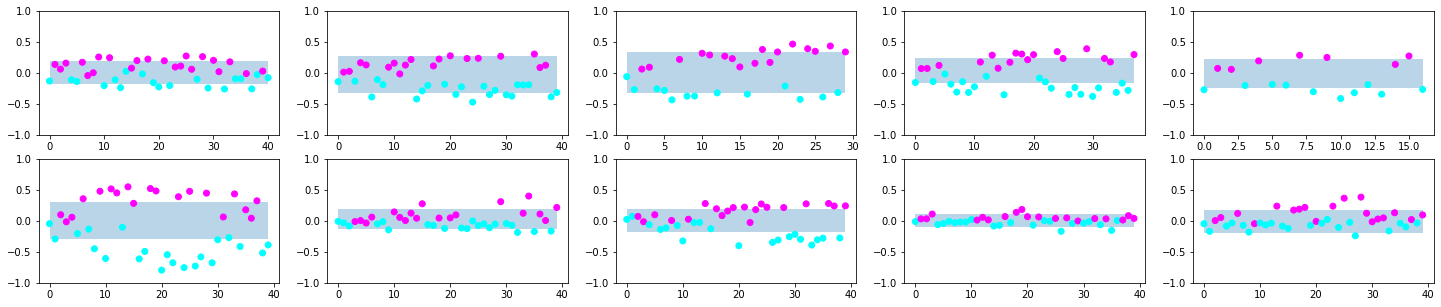

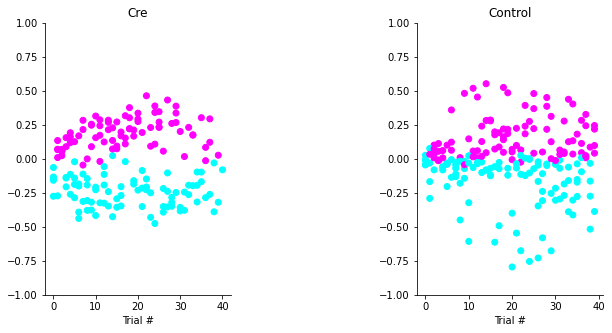

In [42]:
fig, ax = plt.subplots(2,5, figsize = [25,5])

ffig , aax = plt.subplots(1,2, figsize = [10,5])
ffig.subplots_adjust(wspace=1)
aax[0].spines['top'].set_visible(False)
aax[0].spines['right'].set_visible(False)
aax[0].set_xlabel('Trial #')
# aax[0].set_ylabel(r'$log(\frac{cos(\angle_{trial,\bar{left}})}{cos(\angle_{trial,\bar{right})})$',fontsize=20)
aax[0].set_title('Cre')


aax[1].spines['top'].set_visible(False)
aax[1].spines['right'].set_visible(False)
aax[1].set_xlabel('Trial #')
# aax[0].set_ylabel(r'$log(\frac{cos(\angle_{trial,\bar{left}})}{cos(\angle_{trial,\bar{right})})$',fontsize=20)
aax[1].set_title('Control')

day = 0
key = 'spks_norm'

fam = [[],[]]
nov = [[],[]]
for j, mice in enumerate([stx.ymaze_sess_deets.KO_sessions.keys(), stx.ymaze_sess_deets.CTRL_sessions.keys()]):
    for i, mouse in enumerate(mice):
        sess = load_single_day(mouse,day=day)
        dist_mat, shuff_dist_mat = calc_dist_mat(sess, key, metric= 'euclid')

        trials = np.arange(0,dist_mat.shape[0])
        lr = sess.novel_arm*sess.trial_info['LR'][sess.trial_info['block_number']==5]
        
        
#         vals = (dist_mat[:,1]-dist_mat[:,2])/(dist_mat[:,1] + dist_mat[:,2])
        vals = np.log(dist_mat[:,1]) - np.log(dist_mat[:,2])
#         shuff_vals = (shuff_dist_mat[:,:,1]-shuff_dist_mat[:,:,2])/(shuff_dist_mat[:,:,1] + shuff_dist_mat[:,:,2])
        shuff_vals = np.log(shuff_dist_mat[:,:,1]) - np.log(shuff_dist_mat[:,:,2])
#         vals = dist_mat[:,0]

        ax[j,i].scatter(trials, vals, c=lr,cmap='cool')
        ax[j,i].fill_between(trials, np.amax(shuff_vals), np.amin(shuff_vals), alpha = .3,zorder=0)
        print('shuff range',np.amax(shuff_vals),np.amin(shuff_vals))
        ax[j,i].set_ylim([-1,1])
        
        aax[j].scatter(trials, vals, c=lr,cmap='cool')
        aax[j].set_ylim([-1,1])
        
        fam[j].append(np.median(vals[lr==-1]))
        nov[j].append(np.median(vals[lr==1]))
        
figdir = "/mnt/BigDisk/YMazeResults/neural"
ffig.savefig(os.path.join(figdir,"decode_LR_day%d.pdf" % day ), format = "pdf")

In [43]:
t,p = sp.stats.ranksums(*fam)
print(t,p)
t,p = sp.stats.ranksums(*nov)
print(t,p)

-1.3578057164544433 0.17452534056858338
0.9400193421607683 0.34720763934942456


In [2]:
# decode fam vs nov trials within day (LOOCV)

In [3]:
# decode position in fam, test in novel

In [ ]:
# decode position across days 